# *Análisis del Sensado de Corriente*

La señal de corriente de frecuencia $f=50$ Hz con sus armónicos se puede definir como:

$ I_i(t)=A_1\cdot sin(2\pi\cdot f\cdot t) + \sum \limits _{n=2}^{\infty} A_n\cdot sin(2\pi\cdot n \cdot f \cdot t)$

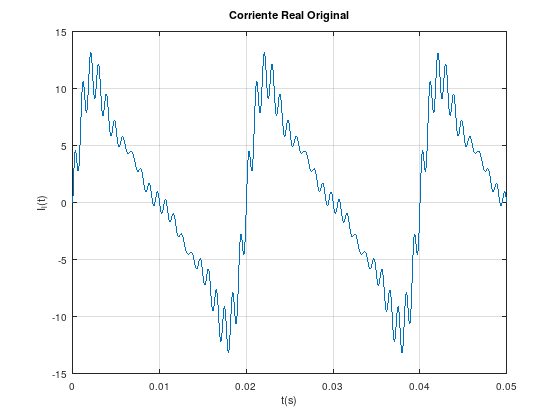

In [68]:
f = 50; % frecuencia fundamental
fs = 40e3; % frecuencia de muestreo
dt = 1/fs; % periodo de muestreo
t = 0:dt:0.05;
A = [8, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.8, 0.6]; % amplitud fundamental y armónicos
Ii = 0;
for n = 1:length(A),
   Ii = Ii + A(n)*sin(2*pi*n*t*f); % inicialización señal de corriente
end;
plot(t,Ii);
title('Corriente Real Original');
grid 'on';
xlabel('t(s)');
ylabel('I_i(t)');

La transconductancia del sensor la convierte en tensión, quedando:

$ I_i(t) \cdot \frac{1V}{10A} = V_i(t) $

$ V_i(t)=\frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{\infty} A_n\cdot sin(2\pi\cdot n \cdot f \cdot t) $

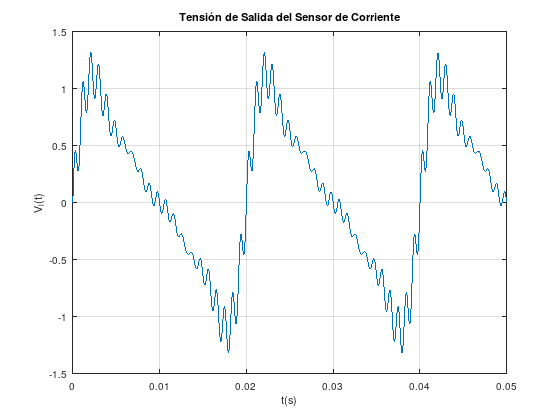

In [69]:
Gm = 0.1; % transconductancia del sensor de corriente
Vi = 0;
for n = 1:length(A),
   Vi = Vi + Gm*A(n)*sin(2*pi*n*t*f); % aplico la transconductancia a la señal
end;
plot(t,Vi);
title('Tensión de Salida del Sensor de Corriente');
grid 'on';
xlabel('t(s)');
ylabel('V_i(t)');

Suponiendo que el filtro antialiasing al tener una frecuencia de corte en $ f_c=1.5 $ KHz no modifica la amplitud de los primeros 20 armónicos y elimina los demás, la tensión luego del filtro entonces se puede expresar como:

$ V_i(t) = \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) $

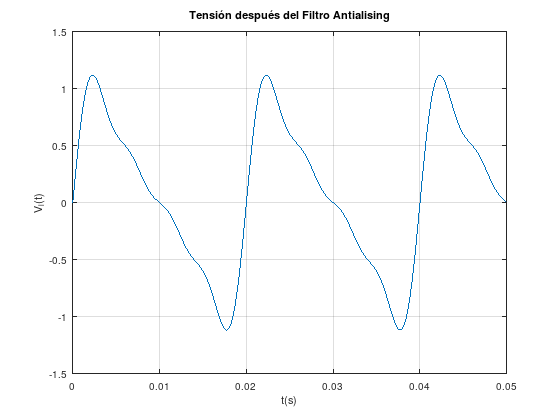

In [70]:
Vi = 0;
for n = 1:20,
   Vi = Vi + Gm*A(n)*sin(2*pi*n*t*f); % Elimino los armónicos que filtramos
end;
plot(t,Vi);
title('Tensión después del Filtro Antialising');
grid 'on';
xlabel('t(s)');
ylabel('V_i(t)');

Al añadirle el offset de 1.5V nos queda:

$ V_i(t) = \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) + 1.5 $

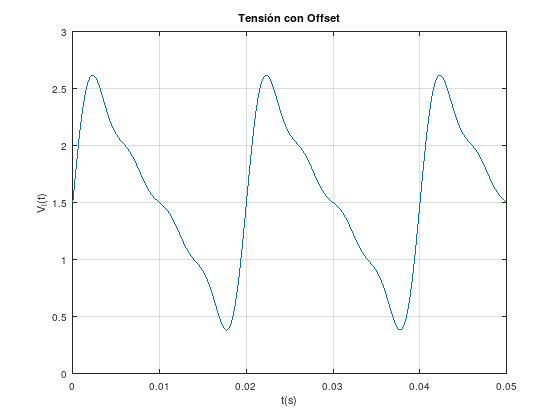

In [71]:
Vi = Vi + 1.5; % añado el offset a la señal
plot(t,Vi);
grid 'on';
title('Tensión con Offset');
xlabel('t(s)');
ylabel('V_i(t)');

La ganancia del amplificador afecta solamente a la componente de alterna, el offset no se ve afectado. Teniendo en cuenta que la ganancia solo varía según la posición del punto medio del potenciómetro digital, esta se puede definir como:

$ G(D_n) = \frac{256}{256-D_n} $

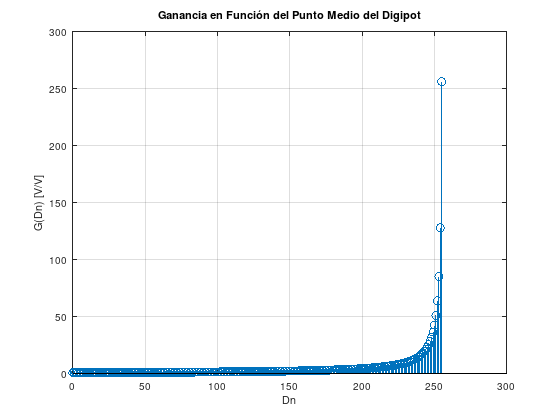

In [72]:
Dn = 0:1:255; % el valor de Dn puede ser cualquier número entero entre 0 y 255, debido a las 256 posiciones del punto medio del digipot
for n = 1:256
    G(n) = 256/(256-Dn(n));
end
stem(Dn,G);
title('Ganancia en Función del Punto Medio del Digipot');
ylabel('G(Dn) [V/V]');
xlabel('Dn');
grid 'on';

Recordando que el valor de $ D_n $ se ajusta automáticamente para aprovechar al máximo la resolución del ADC, en este caso se usaría $ D_n = 60 $, lo que nos da:

$ G(60) =  \frac{256}{256-60} = 1.3061 $

Por lo tanto, la señal de tensión de salida del circuito sería:

$ V_o(t) = G(60) \cdot \frac{A_1}{10}\cdot sin(2\pi\cdot f \cdot t) + G(60)\cdot \frac{1}{10}\sum\limits _{n=2}^{20} A_n\cdot sin(2\pi\cdot n\cdot f\cdot t) + 1.5 $

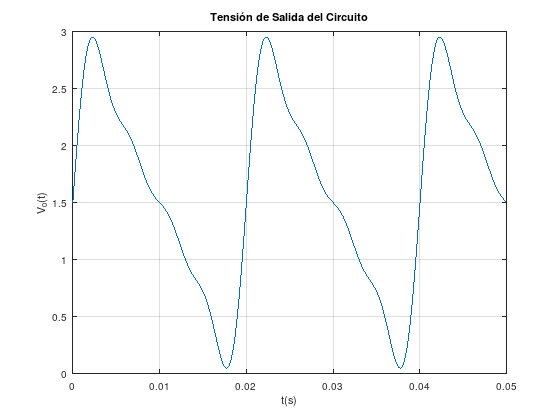

In [73]:
Vo = (Vi - 1.5) * G(60) + 1.5; % aplico la ganancia únicamente a las componentes alternas
plot(t,Vo);
title('Tensión de Salida del Circuito');
grid 'on';
xlabel('t(s)');
ylabel('V_o(t)');

Al muestrear esta señal con el ADC configurado para funcionar con un buffer de 8 bits y una frecuencia de muestreo de 40 KHz, la señal se vería de la siguiente manera:

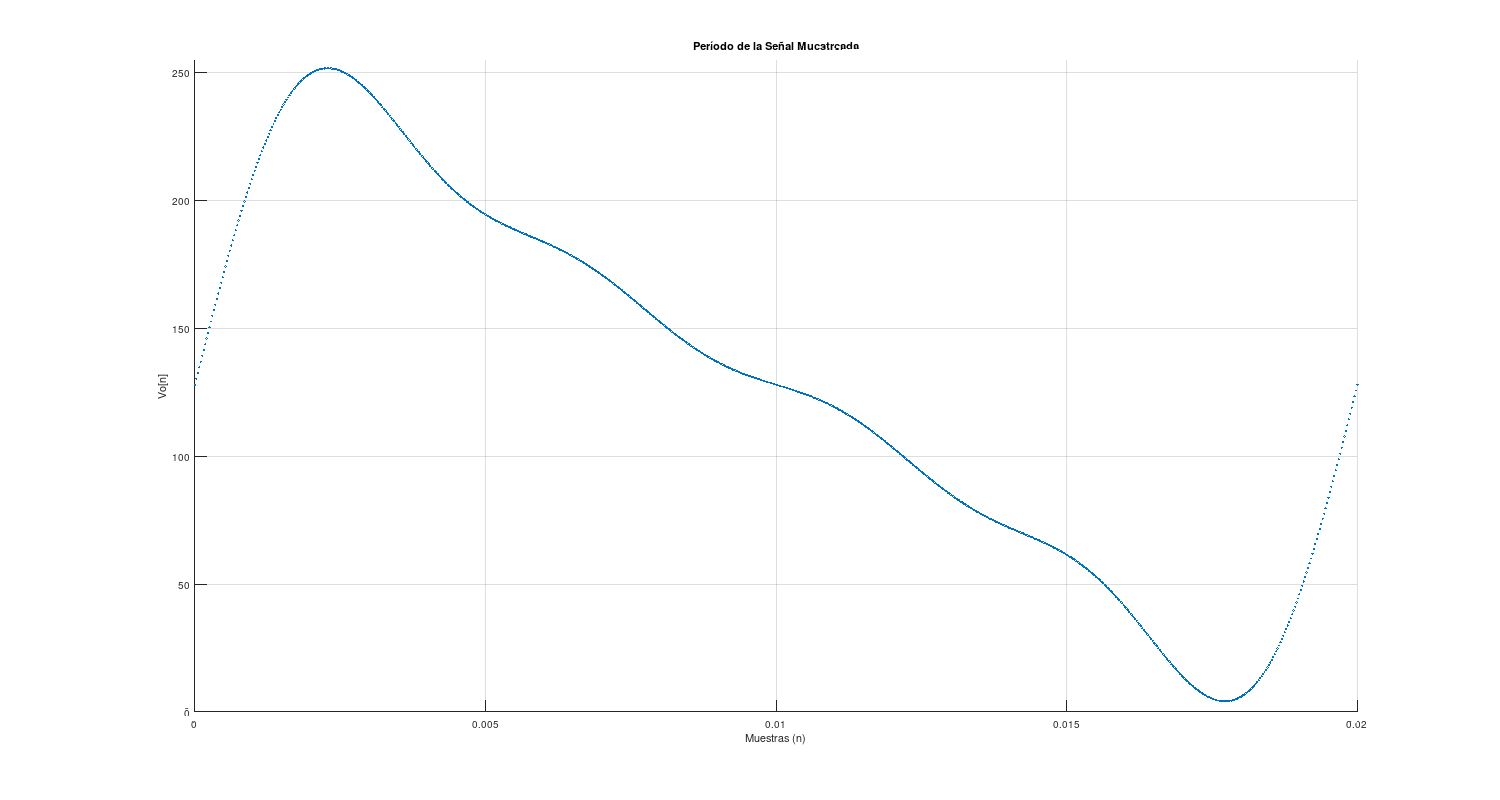

In [74]:
adc_scale = 256/3; % factor de escala al usar 8 bits
Vo_adc = adc_scale * Vo; % aplico el factor de escala

% grafico de forma que se note la discretización
figure;
scatter(t,Vo_adc,1);
set(gcf, 'Position', [0,0,1500,800]);
xlim([0,0.02]);
ylim([0,255]);
title('Período de la Señal Muestreada');
xlabel('Muestras (n)');
ylabel('Vo[n]');
grid 'on';

# Procesamiento dentro de la FPGA

Ahora, pasando a la FPGA tenemos dos señales de corriente:
1) La corriente con armónicos que entrega la fuente $ x[n] $
2) La corriente sinusoidal fundamental de 50Hz $ u[n] $

Para obtener la señal $ u[n] $ se emplea un filtro de media móvil para así eliminar los armónicos de la corriente y dejar solo su componente fundamental de 50 Hz.

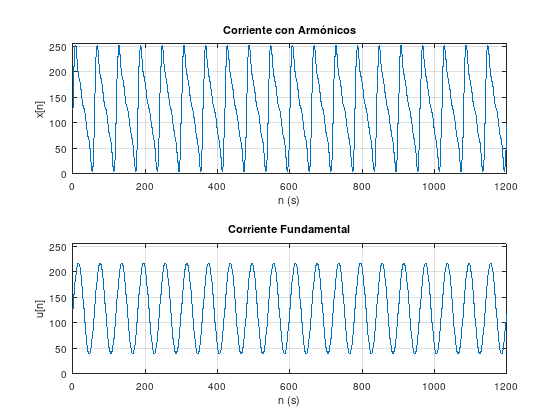

In [91]:
% Señales presentes ya en la FPGA
f = 50;            % frecuencia fundamental 50Hz
fs = 3e3;          % frecuencia de muestreo de 3Ksps
ts = 1/fs;         % período de muestreo
tmax = 0.4;        % tiempo máximo
t = 0:ts:tmax-ts;  % vector de tiempo continuo
n = 0:length(t)-1; % vector de tiempo discreto
A = [8, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.8, 0.6]; % amplitud fundamental y armónicos
x = 0;
for i = 1:20,
   x = x + A(i)*sin(2*pi*i*n*f*ts);
end;
x = (x * Gm * G(60) + 1.5) * adc_scale; % corriente con armónicos
u = (Gm*G(60)*A(1)*sin(2*pi*f*n*ts) + 1.5)*adc_scale; % corriente fundamental de referencia

figure;
subplot(2,1,1);
stairs(n,x);
grid 'on';
title('Corriente con Armónicos');
ylabel('x[n]');
xlabel('n (s)');
ylim([0,255]);
subplot(2,1,2);
stairs(n,u);
grid 'on';
title('Corriente Fundamental');
ylabel('u[n]');
xlabel('n (s)');
ylim([0, 255]);

Ahora se procede a normalizar las señales ya que así facilitamos la tarea al filtro adaptativo predictivo, que es la siguiente etapa en el procesamiento. La normalización se hace calculando la división entre cada una de las señales y el valor de la amplitud de $ x[n] $.

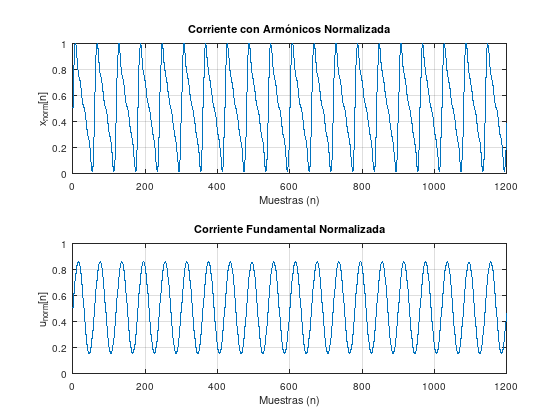

In [92]:
amplitud = max(x);
x_norm = x*(1/amplitud);
u_norm = u*(1/amplitud);

figure;
subplot(2,1,1);
stairs(n,x_norm);
grid 'on';
title('Corriente con Armónicos Normalizada');
ylabel('x_{norm}[n]');
xlabel('Muestras (n)');
ylim([0,1]);
subplot(2,1,2);
stairs(n,u_norm);
grid 'on';
title('Corriente Fundamental Normalizada');
ylabel('u_{norm}[n]');
xlabel('Muestras (n)');
ylim([0, 1]);

Estas señales pasarán ahora por el filtro adaptativo predictivo el cual se basa en un filtro FIR cuyos coeficientes varían con el objetivo de eliminar la componente de 50 Hz de la señal $ x_{norm}[n] $ de esto modo se obtiene la señal $ e[n] $ que no es más que la suma de todos los armónicos de la corriente medida.

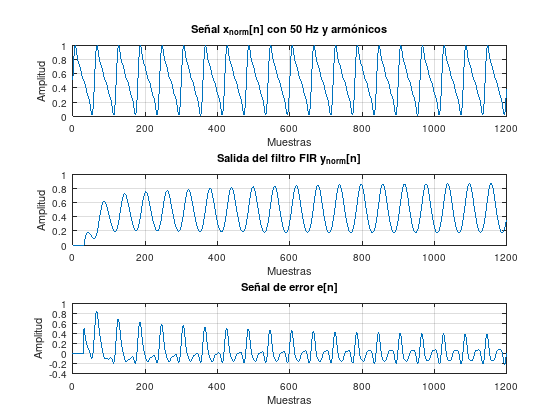

In [93]:
% Parámetros del Filtro
mu = 0.002;                 % tasa de aprendizaje del algoritmo LMS
leaky_factor = 0.999;       % ni idea
cant_coeffs = 32;           % número de coeficientes del filtro FIT (orden)
N = length(n);              % cantidad de muestras
h = zeros(1, cant_coeffs);  % inicialización de los coeficientes del filtro FIR

% Procesamiento de señales
y_norm = zeros(1, N);
e = zeros(1, N);

% Algoritmo LMS
for i = cant_coeffs:N
    % vector de entrada al filtro FIR (ventana de tamaño cant_coeffs de u_norm[n]
    u_vec = u_norm(i:-1:i-cant_coeffs+1);
    % salida del filtro FIR
    y_norm(i) = h * u_vec';
    % señal de error
    e(i) = x_norm(i) - y_norm(i);
    % actualización de los coeficientes del filtro FIR
    h = h + 2*mu*e(i)*u_vec;
end


% Graficar resultados
figure;
subplot(3, 1, 1);
plot(n, x_norm);
title('Señal x_{norm}[n] con 50 Hz y armónicos');
xlabel('Muestras');
ylabel('Amplitud');
grid 'on';

subplot(3, 1, 2);
plot(n, y_norm);
title('Salida del filtro FIR y_{norm}[n]');
xlabel('Muestras');
ylabel('Amplitud');
grid 'on';

subplot(3, 1, 3);
plot(n, e);
title('Señal de error e[n]');
xlabel('Muestras');
ylabel('Amplitud');
grid 'on';

Si bien se ve en la figura anterior que la señal de salida $ e[n] $ es la suma de los armónicos de la señal de entrada $ x_{norm}[n] $ menos la fundamental de 50 Hz que se ve en $ y_{norm}[n] $, para verificar esto es que analizaremos el espectro frecuencial de cada señal.

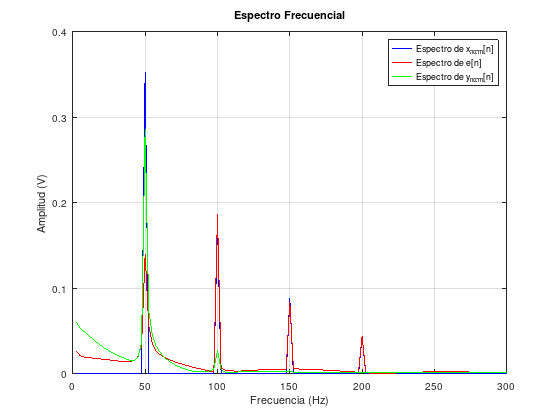

In [116]:
X_f = fft(x_norm);
L = length(X_f);
P2_x = abs(X_f/L);
P1_x = P2_x(2:L/2+1);
P1_x(1:end-1) = 2*P1_x(1:end-1);
fqs = fs*(1:L/2)/L;

E_f = fft(e);
P2_e = abs(E_f/L);
P1_e = P2_e(2:L/2+1);
P1_e(1:end-1) = 2*P1_e(1:end-1);

Y_f = fft(y_norm);
P2_y = abs(Y_f/L);
P1_y = P2_y(2:L/2+1);
P1_y(1:end-1) = 2*P1_y(1:end-1);

plot(fqs,P1_x,'b',fqs,P1_e,'r',fqs,P1_y,'g');
xlim([0,300]);
title('Espectro Frecuencial');
legend('Espectro de x_{norm}[n]', 'Espectro de e[n]', 'Espectro de y_{norm}[n]');
ylabel('Amplitud (V)');
xlabel('Frecuencia (Hz)');
grid 'on';